## Clustering de geopoints por DBSCAN


### Objetivos:
- Aplicar el algoritmo DBSCAN para obtener zonas de alta densidad de accidentes vehiculares en la CDMX.
    
### Desarrollo:
- Indicar un radio $\varepsilon=250$m que tendrá la vecindad. 
- Indicar el número mínimo de accidentes que tendrá la vecindad $min=3$ para ser conciderada una coordenada **significativa**  



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("data/incidentes-viales-c5-limpio.zip", sep="$", index_col=0)

#### Conversión de GPS a matriz de distancias y clustering con DBSCAN

In [5]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [7]:
coords = df[['latitud', 'longitud']].values
kms_per_radian = 6371.009
epsilon = 0.250 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=3, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels)) # Number of cluster with no noise 
# num_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Number of cluster with noise
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 263


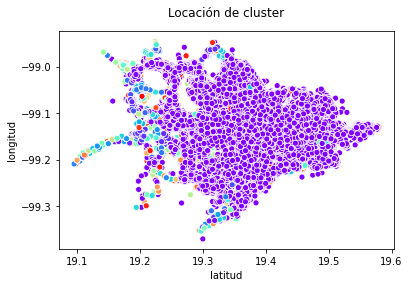

In [8]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('Locación de cluster', pad=15)
ax.set_xlabel('latitud')
ax.set_ylabel('longitud')

sns.scatterplot(df['latitud'], df['longitud'], ax=ax, hue=cluster_labels, palette='rainbow');
# sns.scatterplot(labels[:,0], labels[:,1], ax=ax, s=100, color='black');

ax.get_legend().remove()

#### Encontrar el punto más cercano a cada cluster

In [9]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [10]:
centermost_points = clusters[:len(clusters)-1].map(get_centermost_point)

In [11]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'latitud':lats, 'longitud':lons})

262


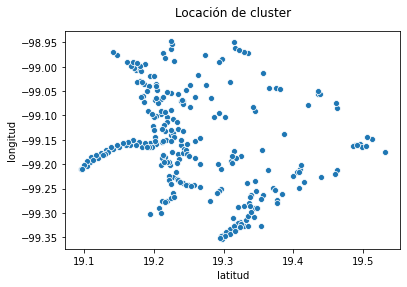

In [12]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('Locación de cluster', pad=15)
ax.set_xlabel('latitud')
ax.set_ylabel('longitud')

sns.scatterplot(rep_points['latitud'], rep_points['longitud'], ax=ax);
# sns.scatterplot(labels[:,0], labels[:,1], ax=ax, s=100, color='black');

In [13]:
# Guardamos las coordenadas de los puntos con mayor densidad 
rep_points.to_csv("most_dangerous_geop.csv")

#### Graficar Gmap

In [15]:
import gmaps

In [16]:
f = open("key.txt")
api_token = f.read() 
gmaps.configure(api_key=api_token)

FileNotFoundError: [Errno 2] No such file or directory: 'key.txt'

##### Heatmap

In [32]:
#Cargamos labels 
dbscan_labels = pd.read_csv("data/dbscan_labels.csv", sep=",", index_col=0)

In [33]:
def labels_to_weights(label):
    if label == -1:
        return 0
    elif label == 0:
        return 1
    else:
        return label        

In [37]:
df['labels'] = dbscan_labels['label'].map(labels_to_weights) 

In [38]:
locations = df[['latitud', 'longitud']]
weights = dbscan_labels
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=df['labels']))
fig

Figure(layout=FigureLayout(height='420px'))

<img src="img/heatmap.png" alt="Maps">

##### Top puntos significativos

In [39]:
#Cargamos coordenadas significativas 
df = pd.read_csv("data/most_dangerous_geop.csv", sep=",", index_col=0)

In [40]:
top_dangerous_geopoints=tuple(zip(df['latitud'], df['longitud']))
fig = gmaps.figure()
markers = gmaps.marker_layer(top_dangerous_geopoints)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

<img src="img/map_most_icon_foto.png" alt="Maps">

Se observa que los puntos con mayor densidad de accidentes ocurren en carreteras. 

#### Reverse geocoding

In [1]:
from geopy.geocoders import Nominatim

In [98]:
def geolocation_fun(row):
    return geolocator.reverse(f"{row[0]}, {row[1]}").raw["address"]
locations_densepoints = df.apply(geolocation_fun, axis=1)

In [46]:
df = pd.read_csv("data/most_dangerous_geop.csv", sep=",", index_col=0)
df_add = pd.DataFrame(locations_densepoints.to_list()).drop(columns=["country", "country_code", "city"])

In [179]:
def road_type(row):
    if row["road"] is np.nan:
        return "Otro"
    elif "Calle" in row["road"]:
        return "Calle"
    elif "Avenida" in row["road"] or "Av." in row["road"] or "Avenda" in row["road"]:
        return "Avenida"
    elif "Carretera" in row["road"]:
        return "Carretera"
    elif "Autopista" in row["road"] or "México-Toluca" in row["road"]:
        return "Autopista"
    else:
        return "Otro"
df_add["vialidad_tipo"] = df_add.apply(road_type, axis=1)
df_add.to_csv("data/descripcion_clusters.csv")

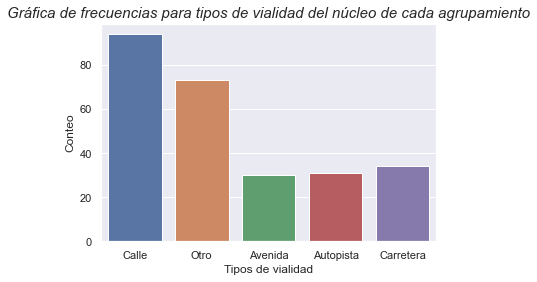

In [129]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="vialidad_tipo", data=df_add)
plt.xlabel("Tipos de vialidad")
plt.ylabel("Conteo")
plt.title("Gráfica de frecuencias para tipos de vialidad del núcleo de cada agrupamiento", style="oblique", fontsize=15);